In [ ]:
library(tidyverse)

In [5]:
#load data
library(tidyverse)
organic_queries  <- read.csv('/Users/lkuncarova/Documents/R_Projekte/google_search_console/data/organic_queries_2019_10_2020_04.csv')
organic_queries_2019  <- read.csv('/Users/lkuncarova/Documents/R_Projekte/google_search_console/data/organic_queries_2019.csv')
paid_queries  <- read.csv('/Users/lkuncarova/Documents/R_Projekte/google_search_console/data/paid_queries_2019_10_2020_04.csv')
paid_queries_stats  <- read.csv('/Users/lkuncarova/Documents/R_Projekte/google_search_console/data/paid_queries_stats_2019_10_2020_04.csv')

In [2]:
summary(organic_queries)

       X                   date                       query        
 Min.   :      1   2020-03-27:  42075   immobilien       :  10023  
 1st Qu.: 387501   2020-03-28:  41796   haus kaufen      :   7019  
 Median : 775000   2020-03-26:  41563   wohnung mieten   :   4006  
 Mean   : 775000   2020-03-22:  41415   immobilienscout24:   3294  
 3rd Qu.:1162500   2020-03-25:  41407   haus             :   2868  
 Max.   :1550000   2020-03-21:  41374   mietwohnung      :   2592  
                   (Other)   :1300370   (Other)          :1520198  
                                                                 page        
 https://www.immobilienscout24.at/                                 :  33634  
 https://www.immobilienscout24.at/wohnen/berghuette.html           :  10819  
 https://www.immobilienscout24.at/wohnen/zwangsversteigerungen.html:  10087  
 https://www.immobilienscout24.at/haus-kaufen.html                 :   9968  
 https://www.immobilienscout24.at/mietwohnungen,wien.html         

In [4]:
organic_queries %>%
arrange(date) %>%
tail()

,X,date,query,page,device,clicks,impressions,ctr,position
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<dbl>
1549995,1183028,2020-04-12,österreich wohnung vermieten,https://www.immobilienscout24.at/ratgeber/eigentuemer/wohnung-vermieten-steuer.html,DESKTOP,1,1,1.00,1
1549996,1183029,2020-04-12,öwg wohnungen gleisdorf,https://www.immobilienscout24.at/regional/steiermark/weiz/gleisdorf/provisionsfreie-wohnung-mieten,MOBILE,1,4,0.25,8
1549997,1183030,2020-04-12,über den linden mieten,https://www.immobilienscout24.at/lp/topimmobilien/strabag_lindengasse.html,MOBILE,1,1,1.00,5
1549998,1183031,2020-04-12,übergabe haus,https://www.immobilienscout24.at/ratgeber/eigentuemer/hausuebergabe-checkliste.html,DESKTOP,1,1,1.00,3
1549999,1183032,2020-04-12,übergabeprotokoll wohnung kauf,https://www.immobilienscout24.at/ratgeber/wohnung-suchen/wohnungsuebergabeprotokoll.html,MOBILE,1,1,1.00,2
1550000,1183033,2020-04-12,übergangswohnung graz,https://www.immobilienscout24.at/regional/steiermark/graz-stadt/wohnen-auf-zeit,DESKTOP,1,1,1.00,3


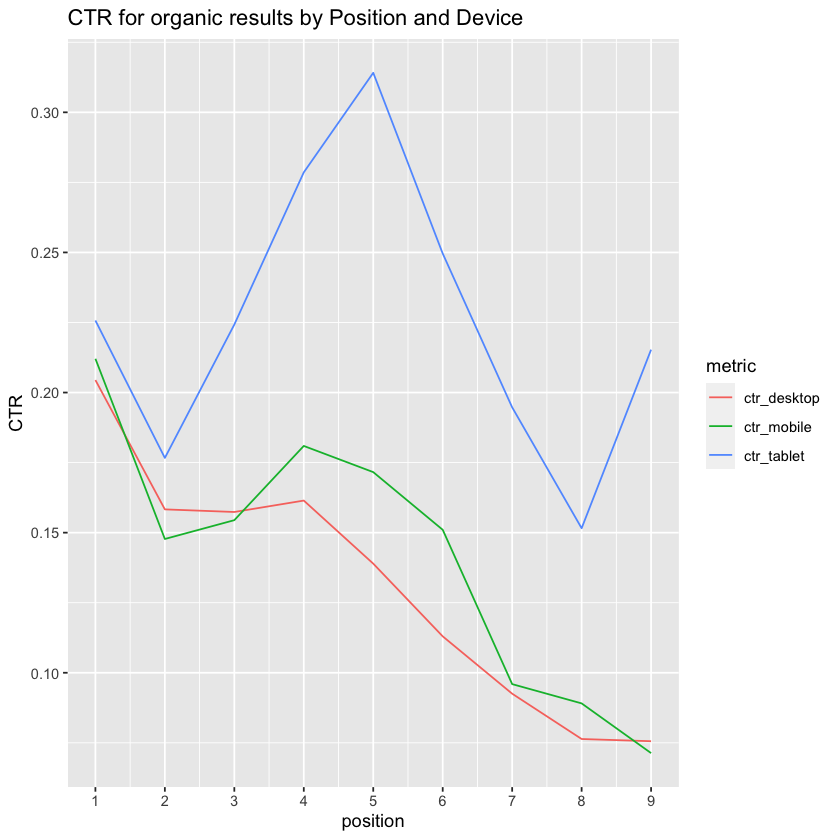

In [120]:
#organic search data
#CTR per device based on position (non-brand queries)
library(reshape)

organic_queries %>% 
  mutate(position = round(position,0)) %>%
  filter(!grepl('scout', query)) %>%
  group_by(position) %>%
  summarize(
    ctr_mobile = sum(clicks[device == 'MOBILE']) / sum(impressions[device == 'MOBILE']),
    ctr_desktop =  sum(clicks[device == 'DESKTOP']) / sum(impressions[device == 'DESKTOP']),
    ctr_tablet =  sum(clicks[device == 'TABLET']) / sum(impressions[device == 'TABLET']),
  ) %>%
  filter(position < 10) %>%
  pivot_longer(-position, names_to = 'metric', values_to = 'value') %>%
ggplot(aes(x = position, y = value, color = metric)) +
  geom_line() + 
  scale_x_continuous(breaks = c(1:10)) +
  labs(title = 'CTR for organic results by Position and Device') +
  ylab('CTR')


- CTR follows similar pattern on desktop and mobile -> possible interpretation: counteracts the assumption that it is necessary to keep paid ads on mobile since user do not scroll further below advertising

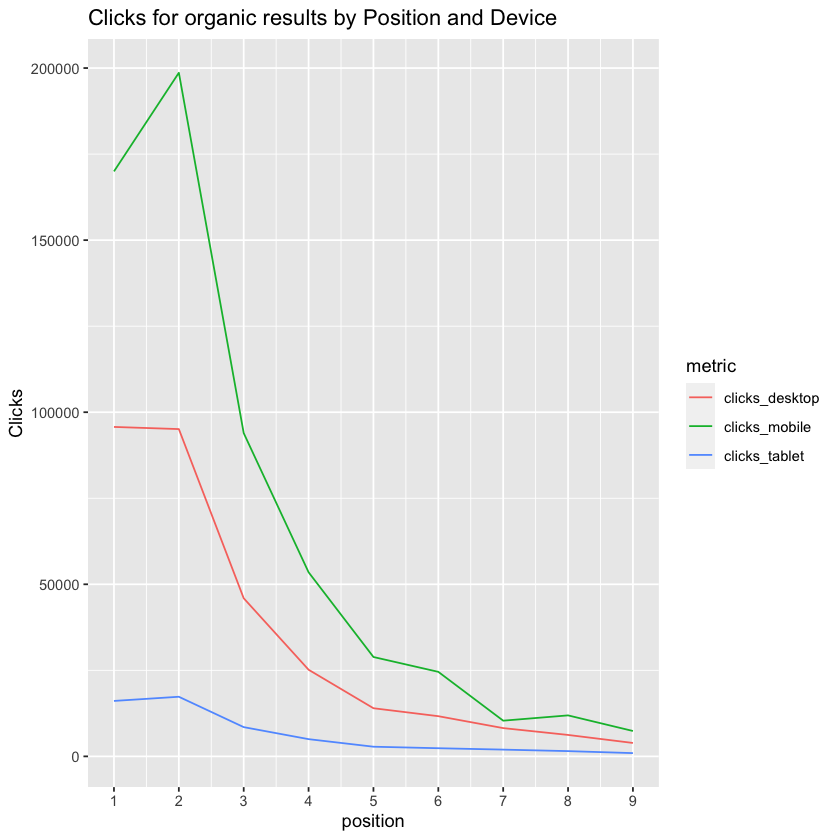

In [128]:
#organic search data
#clicks per device based on position (non-brand queries)
library(reshape)

organic_queries %>% 
  mutate(position = round(position,0)) %>%
  filter(!grepl('scout', query)) %>%
  group_by(position) %>%
  summarize(
    clicks_mobile = sum(clicks[device == 'MOBILE']),
    clicks_desktop =  sum(clicks[device == 'DESKTOP']),
    clicks_tablet =  sum(clicks[device == 'TABLET']),
  ) %>%
  filter(position < 10) %>%
  pivot_longer(-position, names_to = 'metric', values_to = 'value') %>%
ggplot(aes(x = position, y = value, color = metric)) +
  geom_line() + 
  scale_x_continuous(breaks = c(1:10)) +
  labs(title = 'Clicks for organic results by Position and Device') +
  ylab('Clicks')

- majority of organic clicks comes from mobile devices

Warning message:
“Column `query`/`Searchterm` joining factors with different levels, coercing to character vector”


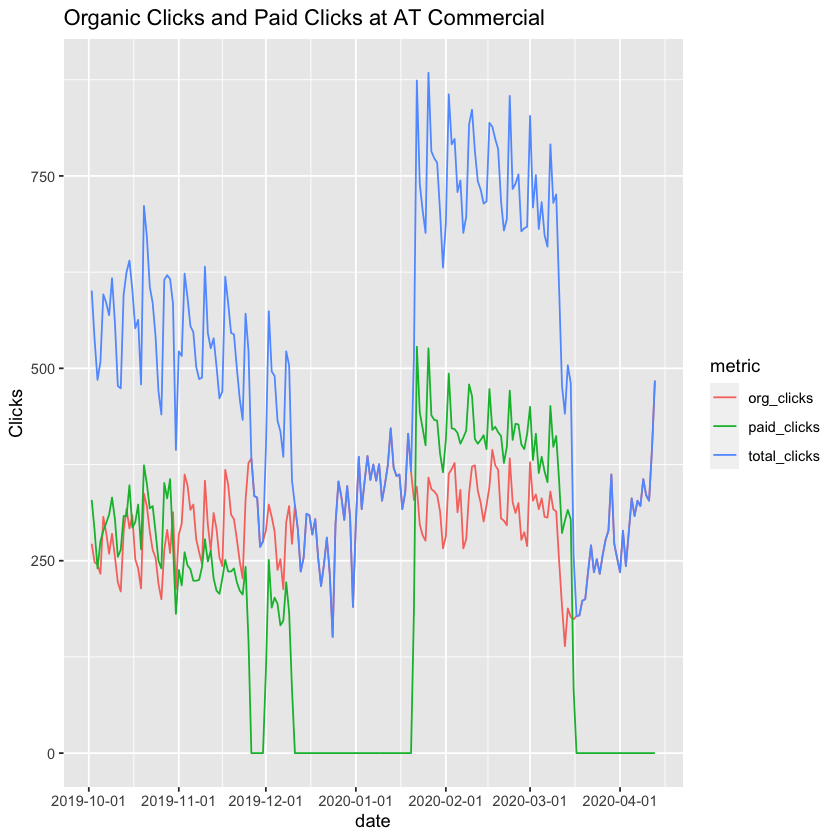

In [10]:
#clicks development organic/paid since the beginning of the year (all devices, all positions, 
# subset of queries which are present both in paid and in organic
paid_queries_stats  <- paid_queries_stats %>%
    mutate(Day = as.Date(Day))


organic_queries %>%
  inner_join(paid_queries, by = c('query' = 'Searchterm')) %>% #inner join with paid qeries
  mutate(date = as.Date(date)) %>%
  filter(date > '2019-10-01') %>%
  group_by(date) %>%
    summarize(
      org_impressions = sum(impressions),
      org_clicks = sum(clicks),
      org_ctr = sum(clicks)/sum(impressions)
    ) %>%
  left_join(paid_queries_stats, by =c('date' = 'Day')) %>%
    replace(is.na(.), 0) %>%
  mutate(
    total_clicks = org_clicks + paid_clicks,
    total_impressions = org_impressions + paid_impressions
  ) %>%
  pivot_longer(-date, names_to = 'metric', values_to = 'value') %>%
  filter(grepl('click', metric)) %>%
ggplot(aes(x = date, y = value, color = metric)) +
  geom_line() + 
  labs(title = 'Organic Clicks and Paid Clicks at AT Commercial') +
  ylab('Clicks') +
  scale_x_date(date_breaks = '1 month')


- Majority of traffic for the queries comes from paid channels
- Paid + organic follow similar weekly patterns
- At first sight, the paid clicks do not generally get recovered by organic results

Warning message:
“Column `query`/`Searchterm` joining factors with different levels, coercing to character vector”


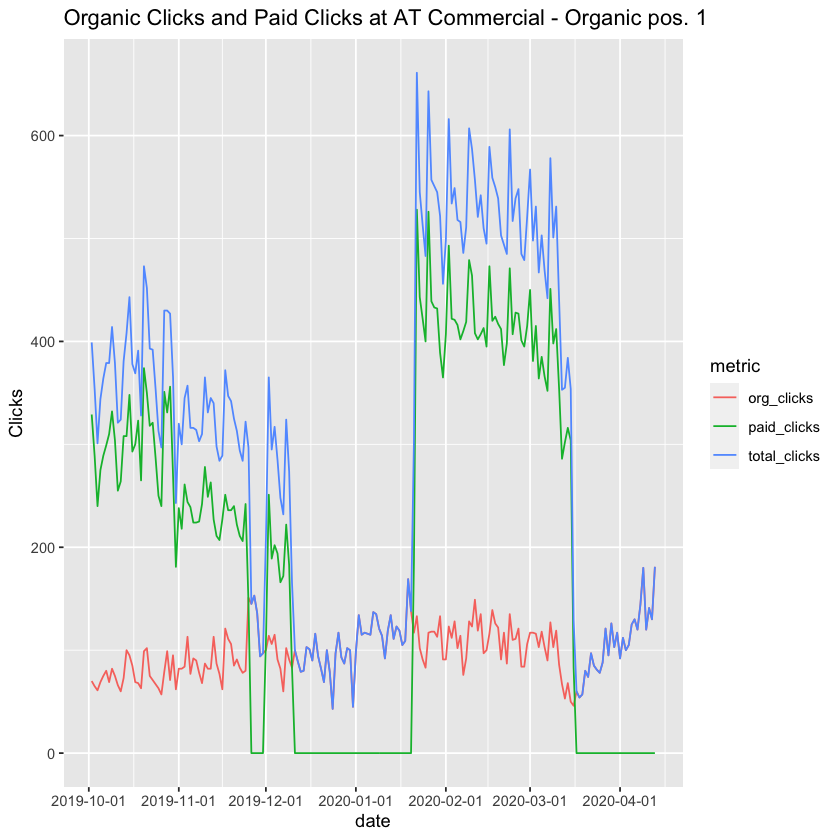

In [13]:
#clicks development organic/paid since the beginning of the year (all devices, position 1, 
# subset of queries which are present both in paid and in organic

organic_queries %>%
  inner_join(paid_queries, by = c('query' = 'Searchterm')) %>% #inner join with paid qeries
  mutate(date = as.Date(date)) %>%
  filter(date > '2019-10-01') %>%
  filter(position <1.5) %>%
  group_by(date) %>%
    summarize(
      org_impressions = sum(impressions),
      org_clicks = sum(clicks),
      org_ctr = sum(clicks)/sum(impressions)
    ) %>%
  left_join(paid_queries_stats, by =c('date' = 'Day')) %>%
    replace(is.na(.), 0) %>%
  mutate(
    total_clicks = org_clicks + paid_clicks,
    total_impressions = org_impressions + paid_impressions
  ) %>%
  pivot_longer(-date, names_to = 'metric', values_to = 'value') %>%
  filter(grepl('click', metric)) %>%
ggplot(aes(x = date, y = value, color = metric)) +
  geom_line() + 
  labs(title = 'Organic Clicks and Paid Clicks at AT Commercial - Organic pos. 1') +
  ylab('Clicks') +
  scale_x_date(date_breaks = '1 month')



- even with paid traffic on position < 1.5, there is no sign of clicks spilling over to organic when paid is paused

Warning message:
“Column `query`/`Searchterm` joining factors with different levels, coercing to character vector”


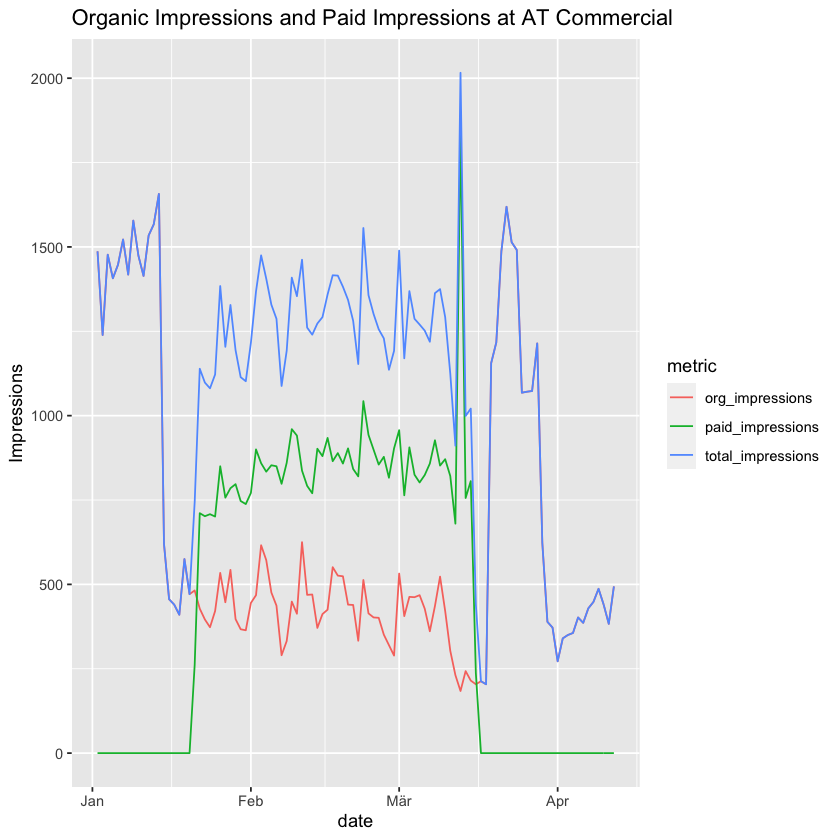

In [142]:
#impressions development since the beginning of the year (all devices, position < 4, queries present in paid)
organic_queries %>%
  inner_join(paid_queries, by = c('query' = 'Searchterm')) %>% #inner join with paid qeries
  mutate(date = as.Date(date)) %>%
  filter(date > '2020-01-01') %>%
  filter(position <4) %>%
  group_by(date) %>%
    summarize(
      org_impressions = sum(impressions),
      org_clicks = sum(clicks),
      org_ctr = sum(clicks)/sum(impressions)
    ) %>%
  left_join(paid_queries_stats, by =c('date' = 'Day')) %>%
    replace(is.na(.), 0) %>%
  mutate(
    total_clicks = org_clicks + paid_clicks,
    total_impressions = org_impressions + paid_impressions
  ) %>%
  pivot_longer(-date, names_to = 'metric', values_to = 'value') %>%
  filter(grepl('impr', metric)) %>%
ggplot(aes(x = date, y = value, color = metric)) +
  geom_line() + 
  labs(title = 'Organic Impressions and Paid Impressions at AT Commercial') +
  ylab('Impressions')


- irregularities in impressions development, two clear peaks in organic impressions in the first half of january and first half of april which are currently inexplicible -> repeat the analysis on other accounts 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



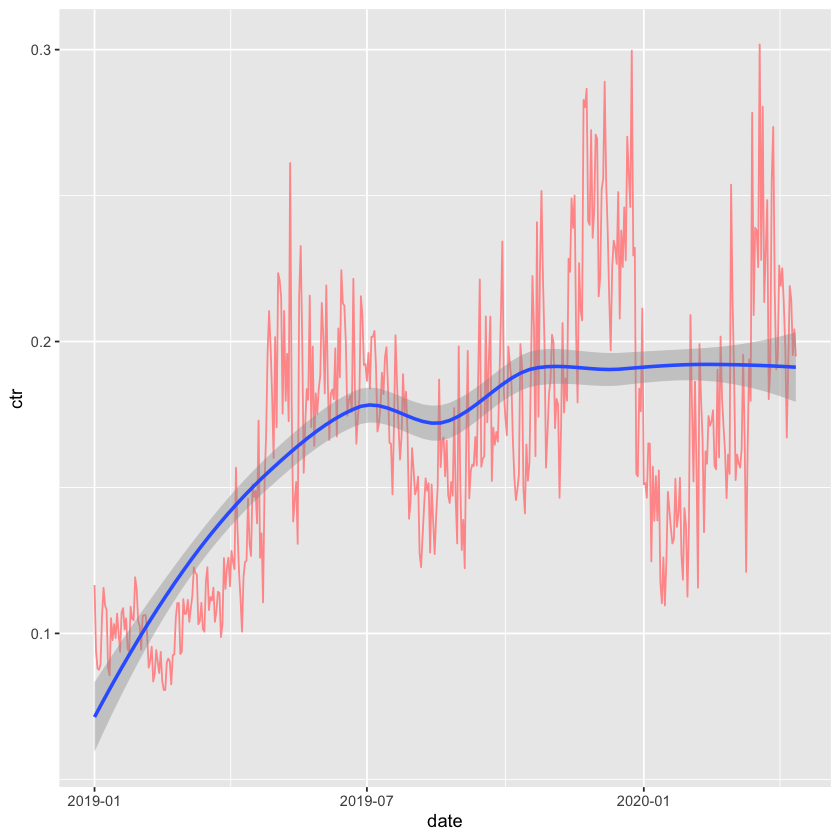

In [114]:
#organic search data
#CTR development over time all positions (non-brand queries)

organic_queries_2019 %>%
  mutate(position = round(position,1)) %>%
  mutate(date = as.Date(date)) %>%
  mutate(category = ifelse(!grepl('scout', query), 'Brand', 'Non-Brand')) %>%
  filter(category == 'Non-Brand') %>%
  filter(position < 4) %>%
  group_by(date) %>%
  summarize(
    ctr = sum(clicks) / sum(impressions)
  ) %>%
    ggplot(mapping = aes(x = date, y = ctr)) +
    geom_line(color = '#FF9999') +
    geom_smooth()

- CTR is increasing with time, possible explanation is increasing brand awareness

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



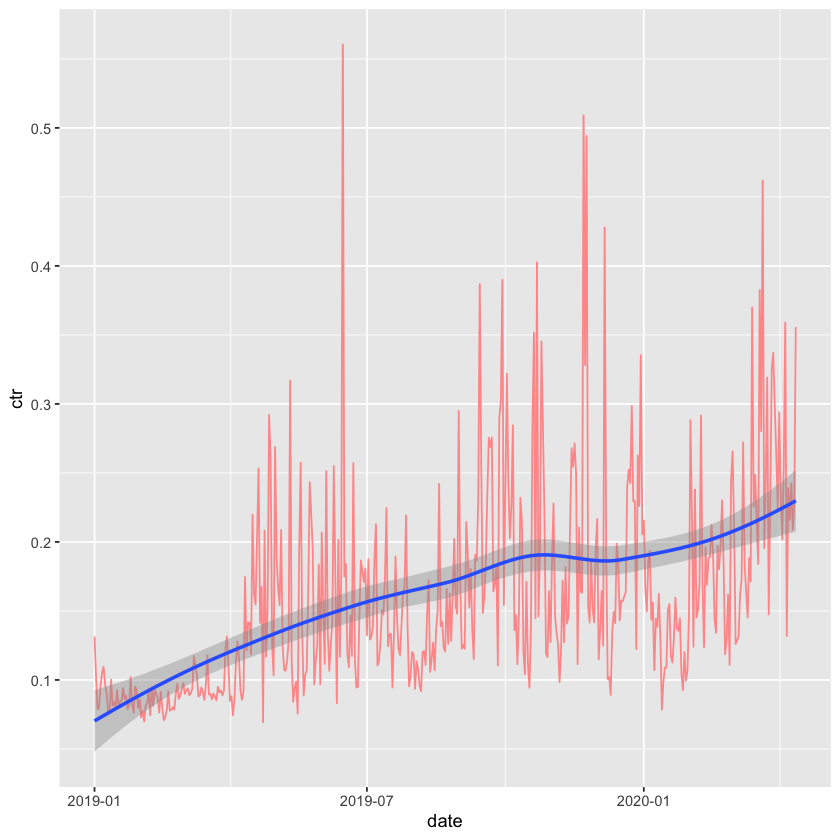

In [115]:
#CTR development over time for non-brand queries on organic position 1

organic_queries_2019 %>%
  mutate(position = round(position,1)) %>%
  mutate(date = as.Date(date)) %>%
  mutate(category = ifelse(!grepl('scout', query), 'Brand', 'Non-Brand')) %>%
  filter(category == 'Non-Brand' & device == 'DESKTOP') %>%
  filter(position < 1.5) %>%
  group_by(date) %>%
  summarize(
    ctr = sum(clicks) / sum(impressions)
  ) %>%
    ggplot(mapping = aes(x = date, y = ctr)) +
    geom_line(color = '#FF9999') +
    geom_smooth()

- CTR increasing even if we only take position 1 results

In [126]:
#compare organic data with concurrent paid ads / without concurrent paid ads for 1. half of March & first half of April
organic_queries %>%
  filter(!grepl('scout', query)) %>% #exclude brand queries
  mutate(category = ifelse(grepl(paste(paid_keywords$KeywordPlacement, collapse = '|'), query), 'is_paid', 'is_not_paid')) %>% #inner join with paid kws
  filter(position < 4) %>% #only queries on relevant positions
  mutate(date = as.Date(date)) %>%
  filter(date > '2020-01-01') %>%
  group_by(category) %>%
  summarize(
    impressions_march = sum(impressions[date >= '2020-03-01' & date <= '2020-03-15']),
    clicks_march = sum(clicks[date >= '2020-03-01' & date <= '2020-03-15']),
    impressions_april = sum(impressions[date >= '2020-04-01' & date <= '2020-04-15']),
    clicks_april = sum(clicks[date >= '2020-04-01' & date <= '2020-04-15']),
  ) %>%
  mutate(ctr_march = clicks_march/impressions_march) %>%
  mutate(ctr_april = clicks_april/impressions_april) %>%
  mutate(perc_change = 1-(ctr_march/ctr_april))

category,impressions_march,clicks_march,impressions_april,clicks_april,ctr_march,ctr_april,perc_change
<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
is_not_paid,354188,100194,317687,94202,0.2828837,0.2965246,0.04600260
is_paid,2494,677,2345,673,0.2714515,0.2869936,0.05415493


- no difference between CTR development for organic queries which are at the same time in paid (comparing two periods, one with active paid ads, one with paused paid ads)